In [30]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.stats import normaltest, shapiro, ttest_ind, mannwhitneyu

In [33]:
ENERGY_FIELD = "PACKAGE_ENERGY (J)"
MEASUREMENTS_PER_SEC = 5
STARTUP_TIME_SEC = 4
EXPERIMENT_TIME_SEC = 11

In [34]:
directory = "2025-04-01_14-00-50"

df_infos = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        run, set, experiment = filename.split(".")[0].split('_')
        df_infos.append({
            "run": run,
            "index": set,
            "experiment": experiment,
            "data": pd.read_csv(filepath)
        })

In [35]:
results = []

for df_info in df_infos:
    df = df_info['data']
    energy_gradients = df[ENERGY_FIELD].diff()
    value = energy_gradients[(MEASUREMENTS_PER_SEC*STARTUP_TIME_SEC):(MEASUREMENTS_PER_SEC*(STARTUP_TIME_SEC+EXPERIMENT_TIME_SEC))].copy()
    
    if df_info['run'] == '0': 
        continue
    
    results.append({
        'run': df_info['run'],
        'applied': int(df_info['index']) <= 11,
        'experiment': df_info['experiment'],
        'value': value[value > 0].sum()
    })

df = pd.DataFrame(results)
df.head()

,run,applied,experiment,value
0,10,True,lazy-elements,10.960693
1,10,True,avoid-resizing-image,11.730957
2,10,True,avoid-gif,61.460815
3,10,False,lazy-elements,11.629883
4,10,False,respect-bfcache,215.735718


In [36]:
EXPERIMENTS = {
	"lazy-elements": "Use lazy attribute",
	"check-link-preload": "Preload link",
	"avoid-canvas": "Avoid using canvas",
	"avoid-gif": "Avoid using gif",
	"prefer-standard-fonts": "Use standard fonts",
	"multiple-console-log": "Avoid logging often",
	"document-fragment": "Use document fragment",
	"intersection-observer": "Use intersection observer",
	"request-animation-frame": "Use request animation frame",
	"repeated-expensive-identifiers": "Avoid expensive identifiers",
	"avoid-resizing-image": "Avoid resizing images",
}

In [37]:
data_all = []
data_set = []
for key, label in EXPERIMENTS.items():
    for is_applied in [True, False]:
        filtered_df = df[(df['experiment'] == key) & (df['applied'] == is_applied)]
        
        for value in filtered_df['value']:
            data_all.append({
                'applied': is_applied,
                'experiment': key,
                'experiment_label': label,
                'value': value,
                'type': 'all'
            })

        q1 = filtered_df['value'].quantile(0.25)
        q3 = filtered_df['value'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_df_no = filtered_df[(filtered_df['value'] >= lower_bound) & (filtered_df['value'] <= upper_bound)]
        
        for value in filtered_df_no['value']:
            data_set.append({
                'applied': is_applied,
                'experiment': key,
                'experiment_label': label,
                'value': value,
                'type': 'no outliers'
            })
        print(key, is_applied, len(filtered_df), len(filtered_df_no))
df_all = pd.DataFrame(data_all)
df_set = pd.DataFrame(data_set)

lazy-elements True 30 27
lazy-elements False 30 28
check-link-preload True 30 27
check-link-preload False 30 26
avoid-canvas True 30 28
avoid-canvas False 30 29
avoid-gif True 30 29
avoid-gif False 30 29
prefer-standard-fonts True 30 26
prefer-standard-fonts False 30 26
multiple-console-log True 30 28
multiple-console-log False 30 26
document-fragment True 30 30
document-fragment False 30 28
intersection-observer True 30 27
intersection-observer False 30 27
request-animation-frame True 30 23
request-animation-frame False 30 29
repeated-expensive-identifiers True 30 28
repeated-expensive-identifiers False 30 28
avoid-resizing-image True 30 27
avoid-resizing-image False 30 28


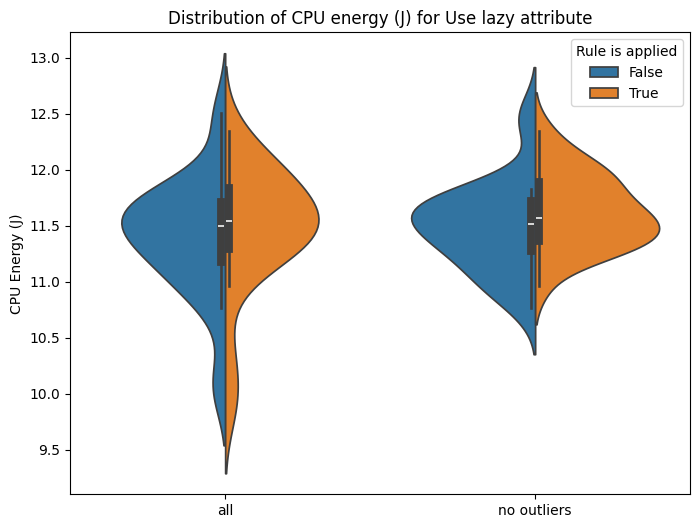

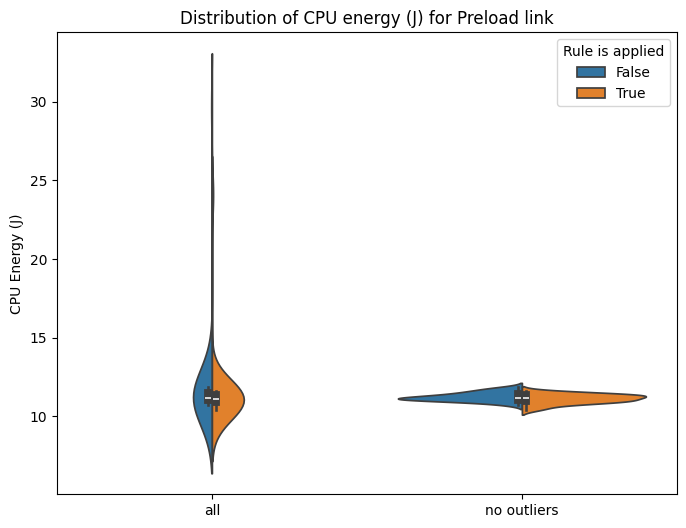

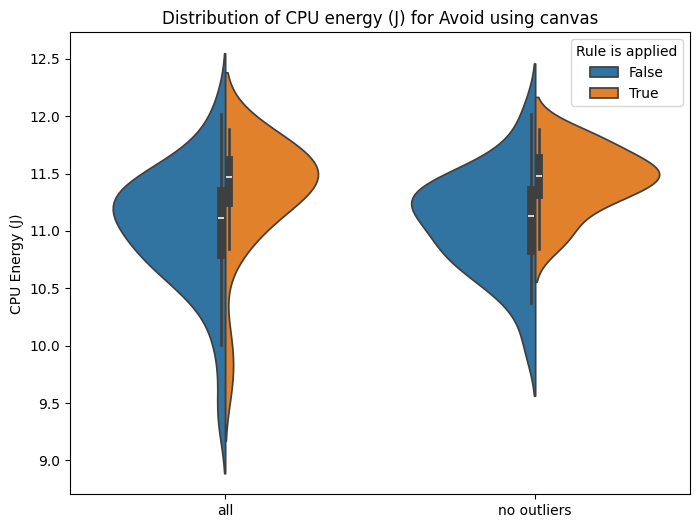

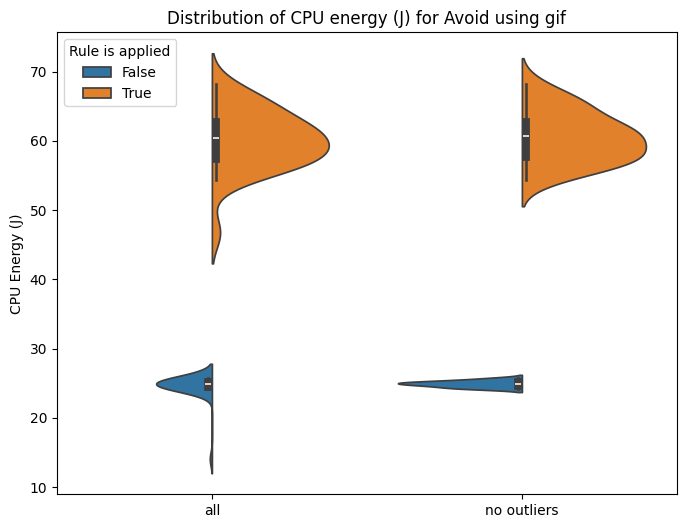

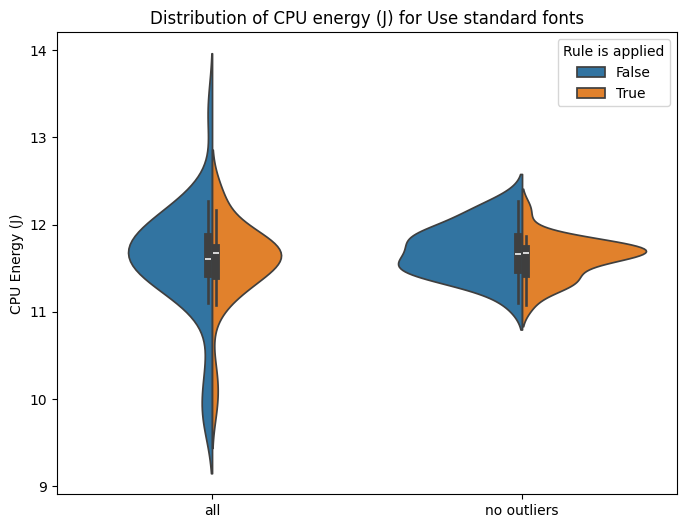

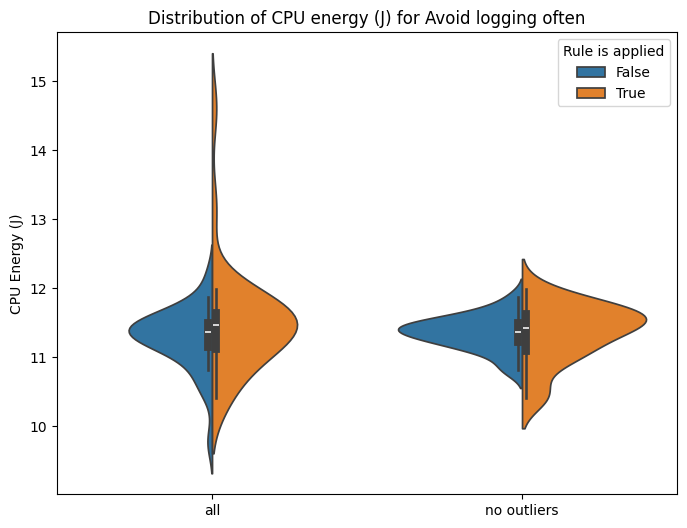

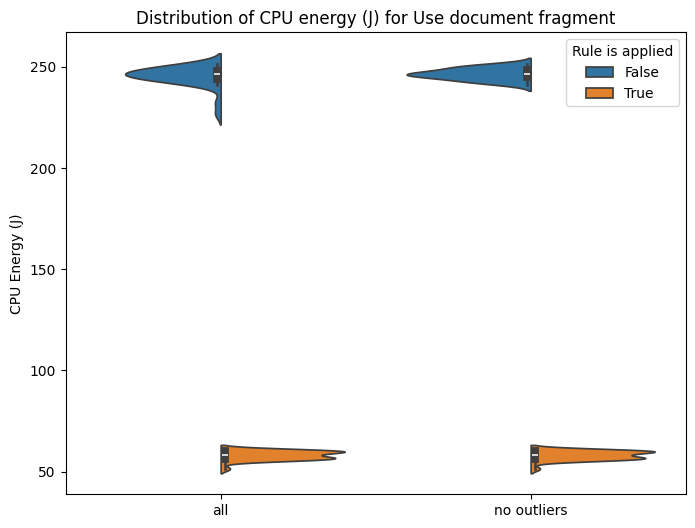

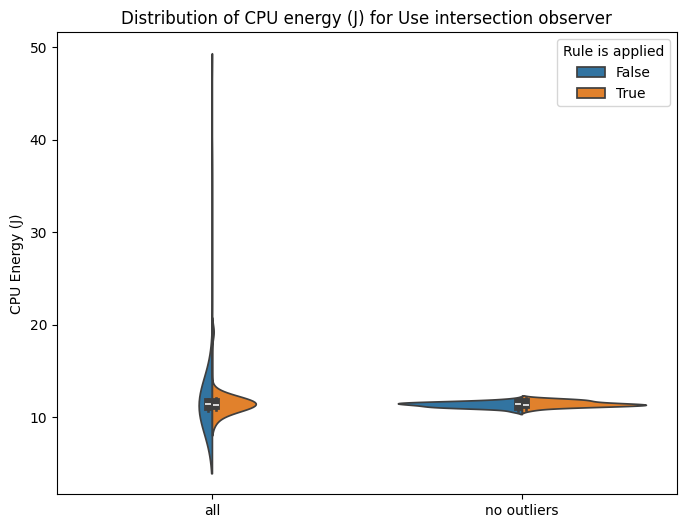

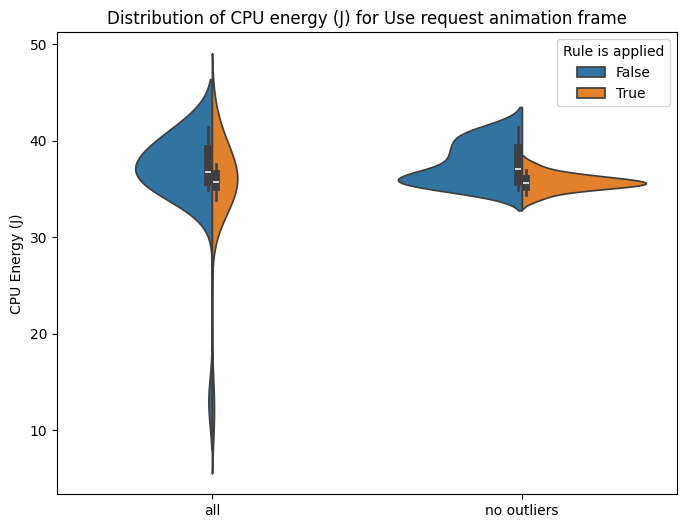

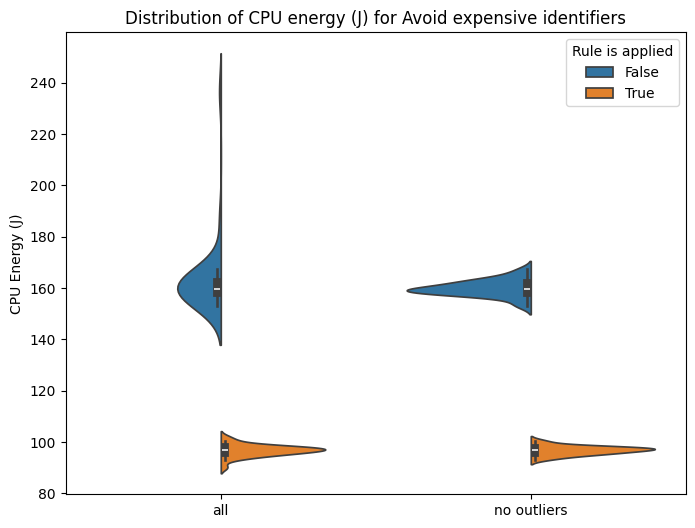

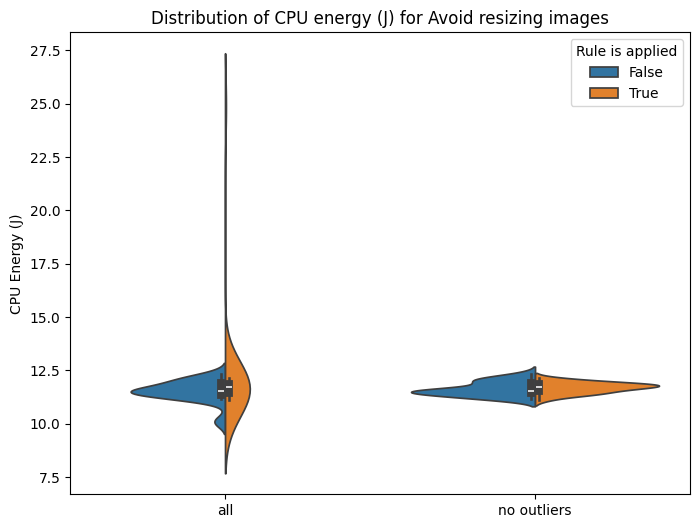

In [38]:
combined_df = pd.concat([df_all, df_set])

for experiment, label in EXPERIMENTS.items():
	plt.figure(figsize=(8, 6))
	sns.violinplot(
		data=combined_df[combined_df['experiment'] == experiment],
		x='type',
		y='value',
		hue='applied',
		split=True
	)
	plt.title(f"Distribution of CPU energy (J) for {label}")
	plt.ylabel("CPU Energy (J)")
	plt.xlabel("")
	plt.legend(title="Rule is applied")
	plt.show()

In [39]:
data = []
data2 = []
for key, label in EXPERIMENTS.items():
	exp_data = []
	for is_applied in [True, False]:
		filtered_df = df_set[(df_set['applied'] == is_applied) & (df_set['experiment'] == key)]

		stat, p = normaltest(filtered_df['value'])
		exp_data.append({
			'experiment': key,
			'mean': filtered_df['value'].mean(),
			'std_dev': filtered_df['value'].std(),
			'p': p,
			'data': filtered_df['value']
		})

	if exp_data[0]['p'] >= 0.05 and exp_data[1]['p'] >= 0.05:
		welch = ttest_ind(exp_data[0]['data'], exp_data[1]['data'], equal_var=False, alternative='two-sided').pvalue
		mwu = "N/A"
	else:
		welch = "N/A"
		mwu = mannwhitneyu(exp_data[0]['data'], exp_data[1]['data'], alternative='two-sided').pvalue

	data.append({
		'Experiment': label,
		'Mean (Applied)': round(exp_data[0]['mean'], 3),
		'Mean (Not applied)': round(exp_data[1]['mean'], 3),
		'Std Dev (Applied)': round(exp_data[0]['std_dev'], 3),
		'Std Dev (Not applied)': round(exp_data[1]['std_dev'], 3),
		'Shapiro-Wilk (Applied)': round(exp_data[0]['p'], 3),
		'Shapiro-Wilk (Not applied)': round(exp_data[1]['p'], 3),
		't-test (p)': ("<0.001" if welch < 0.001 else round(welch, 3)) if welch != "N/A" else welch,
		'U-test (p)': ("<0.001" if mwu < 0.001 else round(mwu, 3)) if mwu != "N/A" else mwu
	})

	data2.append({
		'Experiment': label,
		'Mean diff (ΔX)': round(exp_data[1]['mean'] - exp_data[0]['mean'], 3),
		'Mean change (%)': str(round((exp_data[1]['mean'] - exp_data[0]['mean']) / exp_data[0]['mean'] * 100, 3)) + "%",
		'Effect size (Cohen\'s d)': "N/A" if welch == "N/A" else round((exp_data[1]['mean'] - exp_data[0]['mean']) / numpy.sqrt((exp_data[0]['std_dev'] ** 2 + exp_data[1]['std_dev'] ** 2) / 2), 3)
	})

results_per_set = pd.DataFrame(data)
markdown_table_per_set = results_per_set.to_markdown(index=False)
print(markdown_table_per_set)
print()
results_per_set = pd.DataFrame(data2)
markdown_table_per_set = results_per_set.to_markdown(index=False, colalign=("left", "right", "right", "right"))
print(markdown_table_per_set)

| Experiment                  |   Mean (Applied) |   Mean (Not applied) |   Std Dev (Applied) |   Std Dev (Not applied) |   Shapiro-Wilk (Applied) |   Shapiro-Wilk (Not applied) | t-test (p)   | U-test (p)   |
|:----------------------------|-----------------:|---------------------:|--------------------:|------------------------:|-------------------------:|-----------------------------:|:-------------|:-------------|
| Use lazy attribute          |           11.624 |               11.494 |               0.33  |                   0.4   |                    0.76  |                        0.223 | 0.194        | N/A          |
| Preload link                |           11.102 |               11.24  |               0.298 |                   0.276 |                    0.454 |                        0.561 | 0.087        | N/A          |
| Avoid using canvas          |           11.448 |               11.081 |               0.276 |                   0.43  |                    0.56  |            